In [1]:
import mesa
import math
from epstein_network_civil_violence.agent import Inhabitant, Police
from epstein_network_civil_violence.model import EpsteinNetworkCivilViolence
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm

In [2]:
# Define multi times simulator and plot funtion with confidence interval.
class ModelDataHandler:
    def __init__(self, save_dir):
        self.save_dir = save_dir
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    
    def save_data_to_csv(self, data, filename):
        data.to_csv(filename, index=False)

    def load_data_from_csv(self, filename):
        return pd.read_csv(filename)

    def get_data_filename(self, legitimacy_type, run_index):
        return os.path.join(self.save_dir, f'data_{legitimacy_type}_run_{run_index}.csv')

    def load_all_data(self, legitimacy_type_conditions, num_runs):
        all_data = {}
        for legitimacy_type in legitimacy_type_conditions:
            all_runs_data = []
            for run_index in range(num_runs):
                data_filename = self.get_data_filename(legitimacy_type, run_index)
                data = self.load_data_from_csv(data_filename)
                all_runs_data.append(data['Active_Ratio'])
            all_data[legitimacy_type] = np.array(all_runs_data)
        return all_data

def run_model(legitimacy_type, run_index, data_handler):
    model = EpsteinNetworkCivilViolence(
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.04,
        citizen_vision=4,
        cop_vision=4,
        legitimacy=0.7,
        max_jail_term= 15,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=1000,
        alpha=0,
        jail_factor=1,
        legitimacy_impact=0.002,
        legitimacy_width=0.2,
        use_mean_field=True,
        legitimacy_matrix=np.array([
            [0.9, 0.82, 0.74],
            [0.66, 0.58, 0.5]
        ]),
        legitimacy_type=legitimacy_type
    )

    for _ in range(500):
        model.step()

    data = model.datacollector.get_model_vars_dataframe()
    data_filename = data_handler.get_data_filename(legitimacy_type, run_index)
    data_handler.save_data_to_csv(data, data_filename)

    return data['Active_Ratio']

def run_model_with_different_legitimacy_type(legitimacy_type, num_runs, data_handler):
    all_runs_active_ratio_data = []

    for run_index in tqdm(range(num_runs), desc=f"Runs for legitimacy_type={legitimacy_type}"):
        active_ratio = run_model(legitimacy_type, run_index, data_handler)
        all_runs_active_ratio_data.append(active_ratio)

    all_runs_active_ratio_data = np.array(all_runs_active_ratio_data)
    average_active_ratio_data = np.mean(all_runs_active_ratio_data, axis=0)
    std_err_active_ratio_data = np.std(all_runs_active_ratio_data, axis=0) / math.sqrt(num_runs)

    return average_active_ratio_data, std_err_active_ratio_data

def plot_results(results):
    plt.figure(figsize=(12, 8))
    for legitimacy_type, (average_active_ratio_data, std_err_active_ratio_data) in results.items():
        plt.plot(average_active_ratio_data, label=f'legitimacy_type = {legitimacy_type}') 
        plt.fill_between(range(len(average_active_ratio_data)), 
                         average_active_ratio_data - 1.645 * std_err_active_ratio_data, 
                         average_active_ratio_data + 1.645 * std_err_active_ratio_data, 
                         alpha=0.2)
    plt.xlabel('Time Step')
    plt.ylabel('Average Ratio of Active Citizens over Runs')
    plt.title('Effect of Different legitimacy_type on Active Citizens Over Time')
    plt.legend()
    plt.show()

Overall Progress: 100%|██████████████████████████████████████████████████████████████| 3/3 [5:49:40<00:00, 6993.54s/it]


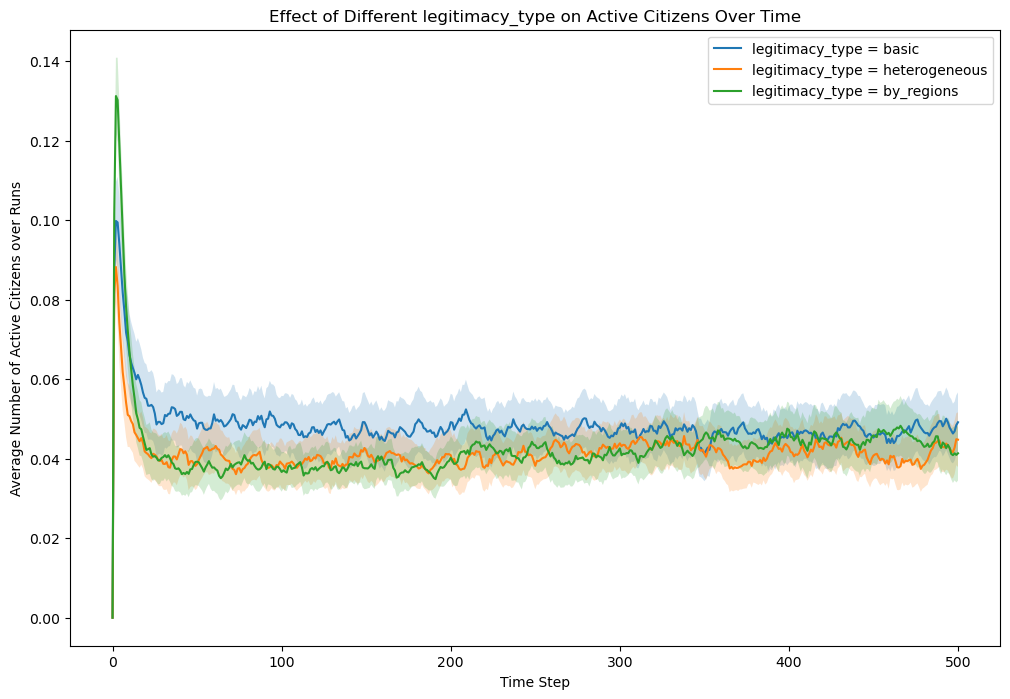

In [19]:
# L= 0.7, legitimacy_impact=0.002, change legitimacy_type, simulated for 100 times with condidence level 90%
legitimacy_type_conditions = ["basic", "heterogeneous", "by_regions"]
num_runs = 100
save_dir = 'saved_data0.002' # Directory to save the data
data_handler = ModelDataHandler(save_dir)
results = {}

for legitimacy_type in tqdm(legitimacy_type_conditions, desc="Overall Progress"):
    results[legitimacy_type] = run_model_with_different_legitimacy_type(legitimacy_type, num_runs, data_handler)

# Plot the results:
plot_results(results)

In [3]:
# adjust function with initial average legitimacy to 0.88
def run_model(legitimacy_type, run_index, data_handler):
    model = EpsteinNetworkCivilViolence(
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.04,
        citizen_vision=4,
        cop_vision=4,
        legitimacy=0.88,
        max_jail_term= 15,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=1000,
        alpha=0,
        jail_factor=1,
        legitimacy_impact=0.002,
        legitimacy_width=0.12,
        use_mean_field=True,
        legitimacy_matrix=np.array([
            [1, 0.94, 0.88],
            [0.88, 0.8, 0.76]
        ]),
        legitimacy_type=legitimacy_type
    )

    for _ in range(500):
        model.step()

    data = model.datacollector.get_model_vars_dataframe()
    data_filename = data_handler.get_data_filename(legitimacy_type, run_index)
    data_handler.save_data_to_csv(data, data_filename)

    return data['Active_Ratio']

Overall Progress: 100%|██████████████████████████████████████████████████████████████| 3/3 [6:10:10<00:00, 7403.58s/it]


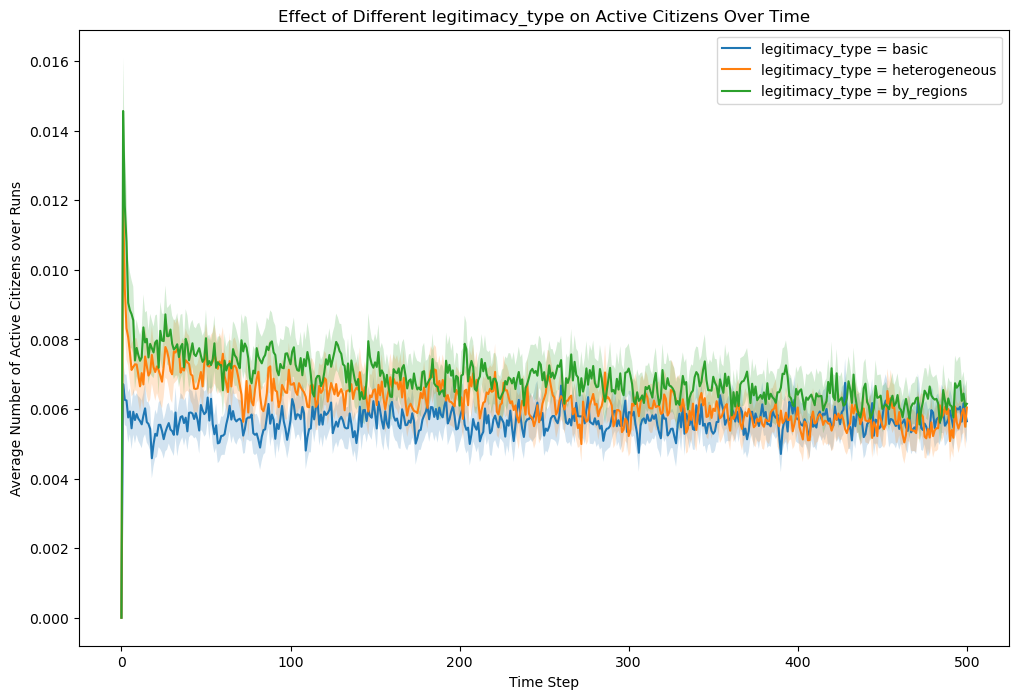

In [15]:
# L= 0.88, legitimacy_impact=0.002, change legitimacy_type, simulated for 100 times with condidence level 90%
legitimacy_type_conditions = ["basic", "heterogeneous", "by_regions"]
num_runs = 100
save_dir = 'saved_dataL0.88' # Directory to save the data
data_handler = ModelDataHandler(save_dir)
results = {}

for legitimacy_type in tqdm(legitimacy_type_conditions, desc="Overall Progress"):
    results[legitimacy_type] = run_model_with_different_legitimacy_type(legitimacy_type, num_runs, data_handler)

# Plot the results:
plot_results(results)

In [4]:
# adjust function, changing alpha in heterogeneous model
def run_model(alpha, run_index, data_handler):
    model = EpsteinNetworkCivilViolence(
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.04,
        citizen_vision=4,
        cop_vision=4,
        legitimacy=0.7,
        max_jail_term= 15,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=1000,
        alpha=alpha,
        jail_factor=1,
        legitimacy_impact=0.005,
        legitimacy_width=0.2,
        use_mean_field=True,
        legitimacy_matrix=np.array([
            [0.9, 0.82, 0.74],
            [0.66, 0.58, 0.5]
        ]),
        legitimacy_type="heterogeneous"
    )

    for _ in range(300):
        model.step()

    data = model.datacollector.get_model_vars_dataframe()
    data_filename = data_handler.get_data_filename(alpha, run_index)
    data_handler.save_data_to_csv(data, data_filename)

    return data['Active_Ratio']

def run_model_with_different_alpha(alpha, num_runs, data_handler):
    all_runs_active_ratio_data = []

    for run_index in tqdm(range(num_runs), desc=f"Runs for alpha={alpha}"):
        active_ratio = run_model(alpha, run_index, data_handler)
        all_runs_active_ratio_data.append(active_ratio)

    all_runs_active_ratio_data = np.array(all_runs_active_ratio_data)
    average_active_ratio_data = np.mean(all_runs_active_ratio_data, axis=0)
    std_err_active_ratio_data = np.std(all_runs_active_ratio_data, axis=0) / math.sqrt(num_runs)

    return average_active_ratio_data, std_err_active_ratio_data

def plot_results(results):
    plt.figure(figsize=(12, 8))
    for alpha, (average_active_ratio_data, std_err_active_ratio_data) in results.items():
        plt.plot(average_active_ratio_data, label=f'alpha = {alpha}') 
        plt.fill_between(range(len(average_active_ratio_data)), 
                         average_active_ratio_data - 1.645 * std_err_active_ratio_data, 
                         average_active_ratio_data + 1.645 * std_err_active_ratio_data, 
                         alpha=0.2)
    plt.xlabel('Time Step')
    plt.ylabel('Average Ratio of Active Citizens over Runs')
    plt.title('Effect of Different Alpha on Active Citizens Over Time')
    plt.legend()
    plt.show()

Overall Progress: 100%|██████████████████████████████████████████████████████████████| 3/3 [3:09:52<00:00, 3797.36s/it]


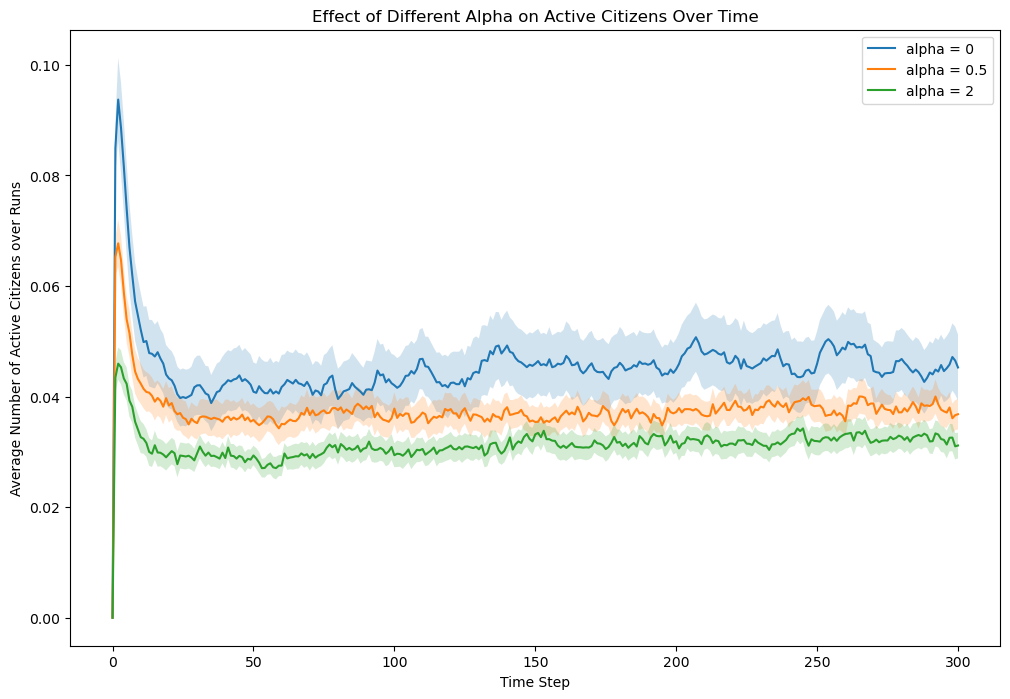

In [16]:
# change alpha in heterogeneous model, simulated for 100 times with condidence level 90%
alpha = [0, 0.5, 2]
num_runs = 100
save_dir = 'saved_data_alpha_1' # Directory to save the data
data_handler = ModelDataHandler(save_dir)
results = {}

for alpha in tqdm(alpha, desc="Overall Progress"):
    results[alpha] = run_model_with_different_alpha(alpha, num_runs, data_handler)

plot_results(results)

In [5]:
# adjust function, changing alpha in by_regions model
def run_model(alpha, run_index, data_handler):
    model = EpsteinNetworkCivilViolence(
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.04,
        citizen_vision=4,
        cop_vision=4,
        legitimacy=0.7,
        max_jail_term= 15,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=1000,
        alpha=alpha,
        jail_factor=1,
        legitimacy_impact=0.005,
        legitimacy_width=0.2,
        use_mean_field=True,
        legitimacy_matrix=np.array([
            [0.9, 0.82, 0.74],
            [0.66, 0.58, 0.5]
        ]),
        legitimacy_type="by_regions"
    )

    for _ in range(300):
        model.step()

    data = model.datacollector.get_model_vars_dataframe()
    data_filename = data_handler.get_data_filename(alpha, run_index)
    data_handler.save_data_to_csv(data, data_filename)

    return data['Active_Ratio']

Overall Progress: 100%|██████████████████████████████████████████████████████████████| 3/3 [3:18:44<00:00, 3974.89s/it]


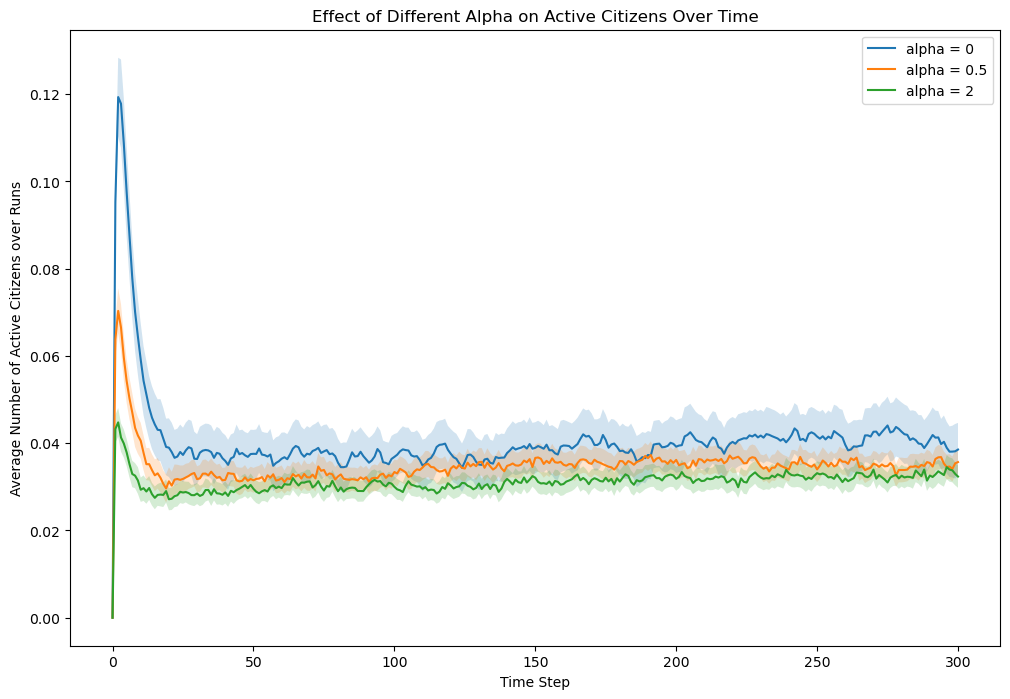

In [19]:
# change alpha in by_regions model, simulated for 100 times with condidence level 90%
alpha = [0, 0.5, 2]
num_runs = 100
save_dir = 'saved_data_alpha_by_regions' # Directory to save the data
data_handler = ModelDataHandler(save_dir)
results = {}

for alpha in tqdm(alpha, desc="Overall Progress"):
    results[alpha] = run_model_with_different_alpha(alpha, num_runs, data_handler)

plot_results(results)

In [22]:
# adjust function, changing alpha in basic model
def run_model(alpha, run_index, data_handler):
    model = EpsteinNetworkCivilViolence(
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.04,
        citizen_vision=4,
        cop_vision=4,
        legitimacy=0.7,
        max_jail_term= 15,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=1000,
        alpha=alpha,
        jail_factor=1,
        legitimacy_impact=0.005,
        legitimacy_width=0.2,
        use_mean_field=True,
        legitimacy_matrix=np.array([
            [0.9, 0.82, 0.74],
            [0.66, 0.58, 0.5]
        ]),
        legitimacy_type="basic"
    )

    for _ in range(300):
        model.step()

    data = model.datacollector.get_model_vars_dataframe()
    data_filename = data_handler.get_data_filename(alpha, run_index)
    data_handler.save_data_to_csv(data, data_filename)

    return data['Active_Ratio']

Overall Progress: 100%|██████████████████████████████████████████████████████████████| 3/3 [3:15:22<00:00, 3907.38s/it]


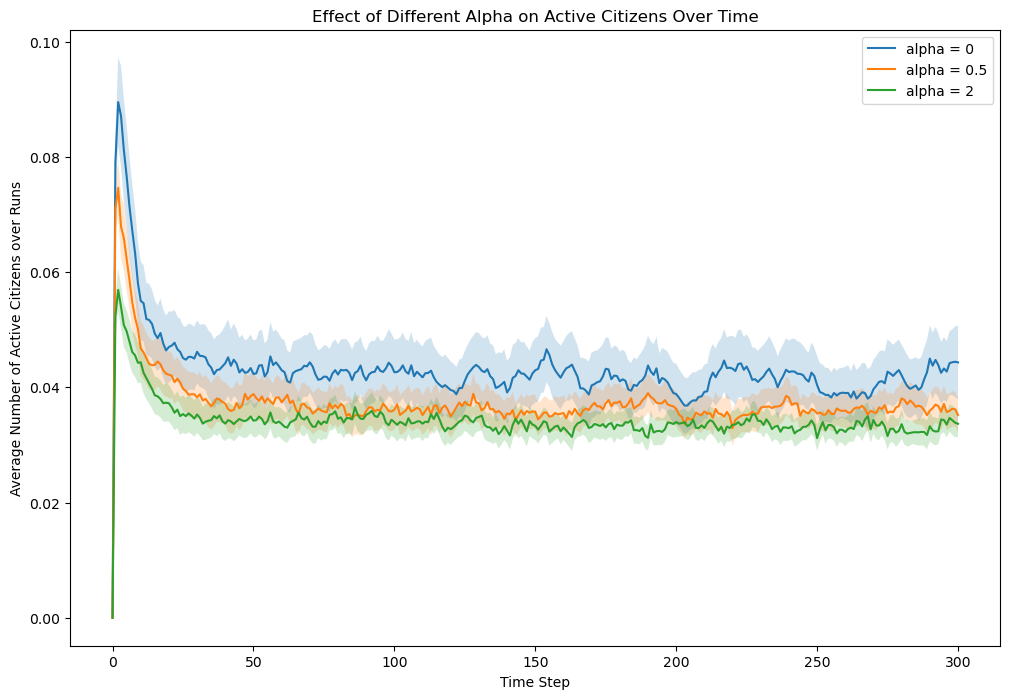

In [23]:
# change alpha in basic model, simulated for 100 times with condidence level 90%
alpha = [0, 0.5, 2]
num_runs = 100
save_dir = 'saved_data_alpha_basic' # Directory to save the data
data_handler = ModelDataHandler(save_dir)
results = {}

for alpha in tqdm(alpha, desc="Overall Progress"):
    results[alpha] = run_model_with_different_alpha(alpha, num_runs, data_handler)

plot_results(results)

In [3]:
# adjust function, changing jail_factor in heterogeneous model
def run_model(jail_factor, run_index, data_handler):
    model = EpsteinNetworkCivilViolence(
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.04,
        citizen_vision=4,
        cop_vision=4,
        legitimacy=0.7,
        max_jail_term= 15,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=1000,
        alpha=0.5,
        jail_factor=jail_factor,
        legitimacy_impact=0.005,
        legitimacy_width=0.2,
        use_mean_field=True,
        legitimacy_matrix=np.array([
            [0.9, 0.82, 0.74],
            [0.66, 0.58, 0.5]
        ]),
        legitimacy_type="heterogeneous"
    )

    for _ in range(300):
        model.step()

    data = model.datacollector.get_model_vars_dataframe()
    data_filename = data_handler.get_data_filename(jail_factor, run_index)
    data_handler.save_data_to_csv(data, data_filename)

    return data['Active_Ratio']

def run_model_with_different_jail_factor(jail_factor, num_runs, data_handler):
    all_runs_active_ratio_data = []

    for run_index in tqdm(range(num_runs), desc=f"Runs for jail_factor={jail_factor}"):
        active_ratio = run_model(jail_factor, run_index, data_handler)
        all_runs_active_ratio_data.append(active_ratio)

    all_runs_active_ratio_data = np.array(all_runs_active_ratio_data)
    average_active_ratio_data = np.mean(all_runs_active_ratio_data, axis=0)
    std_err_active_ratio_data = np.std(all_runs_active_ratio_data, axis=0) / math.sqrt(num_runs)

    return average_active_ratio_data, std_err_active_ratio_data

def plot_results(results):
    plt.figure(figsize=(12, 8))
    for jail_factor, (average_active_ratio_data, std_err_active_ratio_data) in results.items():
        plt.plot(average_active_ratio_data, label=f'jail_factor = {jail_factor}') 
        plt.fill_between(range(len(average_active_ratio_data)), 
                         average_active_ratio_data - 1.645 * std_err_active_ratio_data, 
                         average_active_ratio_data + 1.645 * std_err_active_ratio_data, 
                         alpha=0.2)
    plt.xlabel('Time Step')
    plt.ylabel('Average Number of Active Citizens over Runs')
    plt.title('Effect of Different jail_factor on Active Citizens Over Time')
    plt.legend()
    plt.show()

Overall Progress: 100%|██████████████████████████████████████████████████████████████| 3/3 [3:12:51<00:00, 3857.27s/it]


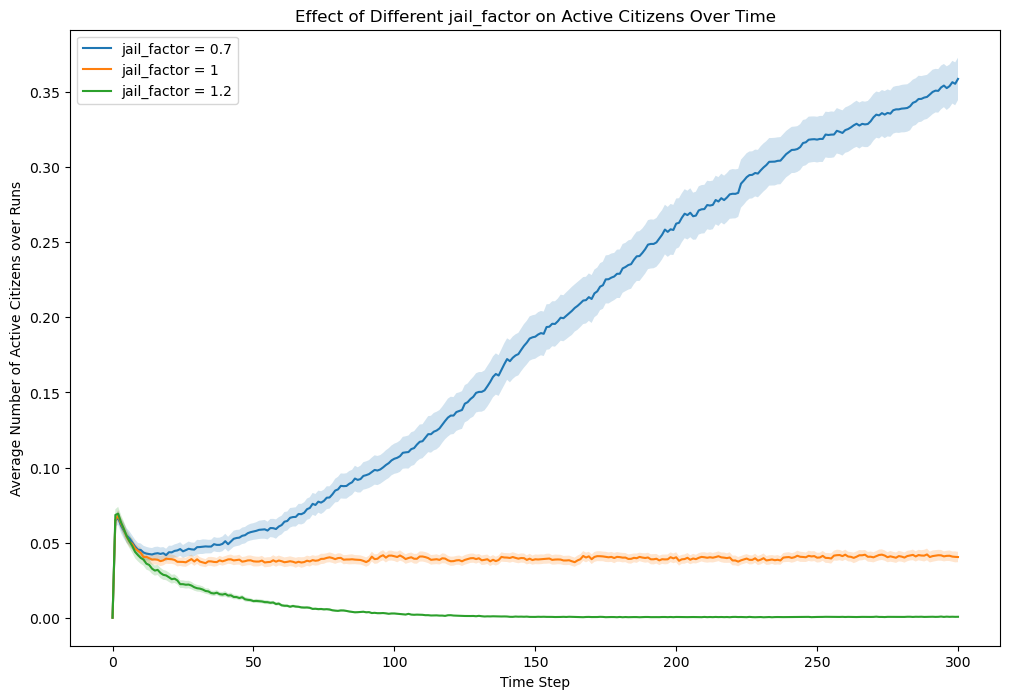

In [5]:
# change jail_factor in heterogeneous model, simulated for 100 times with condidence level 90%
jail_factor = [0.7, 1, 1.2]
num_runs = 100
save_dir = 'saved_data_jail_factor_heterogeneous' # Directory to save the data
data_handler = ModelDataHandler(save_dir)
results = {}

for jail_factor in tqdm(jail_factor, desc="Overall Progress"):
    results[jail_factor] = run_model_with_different_jail_factor(jail_factor, num_runs, data_handler)

# Plot the results:
plot_results(results)

In [7]:
# adjust function, changing jail_factor in by_regions model
def run_model(jail_factor, run_index, data_handler):
    model = EpsteinNetworkCivilViolence(
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.04,
        citizen_vision=4,
        cop_vision=4,
        legitimacy=0.7,
        max_jail_term= 15,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=1000,
        alpha=0.5,
        jail_factor=jail_factor,
        legitimacy_impact=0.005,
        legitimacy_width=0.2,
        use_mean_field=True,
        legitimacy_matrix=np.array([
            [0.9, 0.82, 0.74],
            [0.66, 0.58, 0.5]
        ]),
        legitimacy_type="by_regions"
    )

    for _ in range(300):
        model.step()

    data = model.datacollector.get_model_vars_dataframe()
    data_filename = data_handler.get_data_filename(jail_factor, run_index)
    data_handler.save_data_to_csv(data, data_filename)

    return data['Active_Ratio']

Overall Progress: 100%|██████████████████████████████████████████████████████████████| 3/3 [3:19:50<00:00, 3996.86s/it]


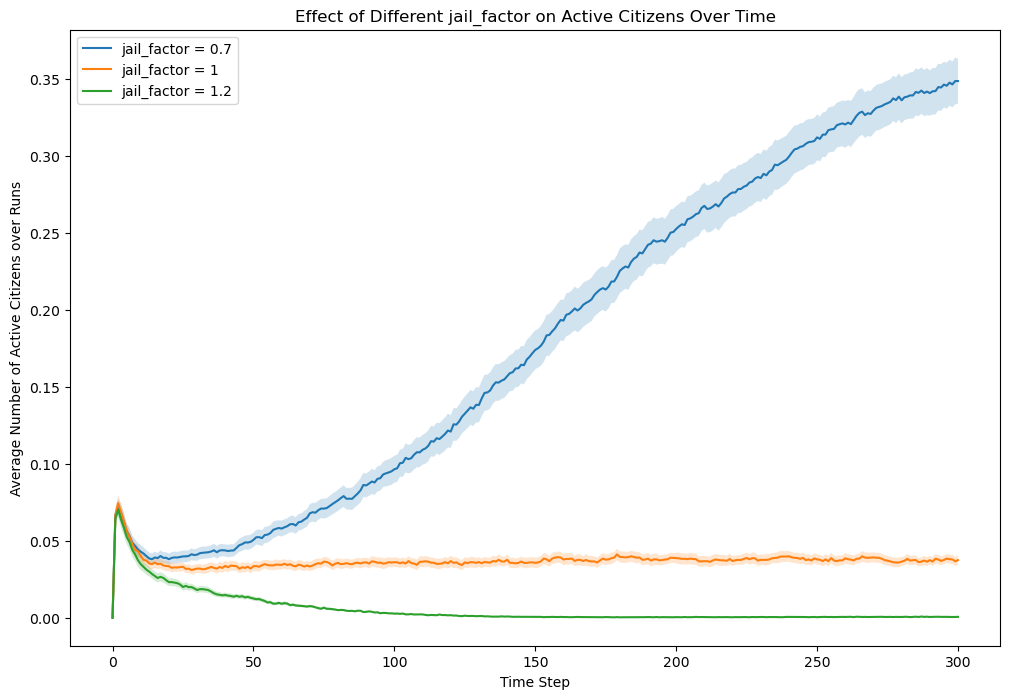

In [8]:
# change jail_factor in by_regions model, simulated for 100 times with condidence level 90%
jail_factor = [0.7, 1, 1.2]
num_runs = 100
save_dir = 'saved_data_jail_factor_by_regions' # Directory to save the data
data_handler = ModelDataHandler(save_dir)
results = {}

for jail_factor in tqdm(jail_factor, desc="Overall Progress"):
    results[jail_factor] = run_model_with_different_jail_factor(jail_factor, num_runs, data_handler)

# Plot the results:
plot_results(results)

In [10]:
# adjust function, changing jail_factor in basic model
def run_model(jail_factor, run_index, data_handler):
    model = EpsteinNetworkCivilViolence(
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.04,
        citizen_vision=4,
        cop_vision=4,
        legitimacy=0.7,
        max_jail_term= 15,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=1000,
        alpha=0.5,
        jail_factor=jail_factor,
        legitimacy_impact=0.005,
        legitimacy_width=0.2,
        use_mean_field=True,
        legitimacy_matrix=np.array([
            [0.9, 0.82, 0.74],
            [0.66, 0.58, 0.5]
        ]),
        legitimacy_type="basic"
    )

    for _ in range(300):
        model.step()

    data = model.datacollector.get_model_vars_dataframe()
    data_filename = data_handler.get_data_filename(jail_factor, run_index)
    data_handler.save_data_to_csv(data, data_filename)

    return data['Active_Ratio']

Overall Progress: 100%|██████████████████████████████████████████████████████████████| 3/3 [3:15:40<00:00, 3913.66s/it]


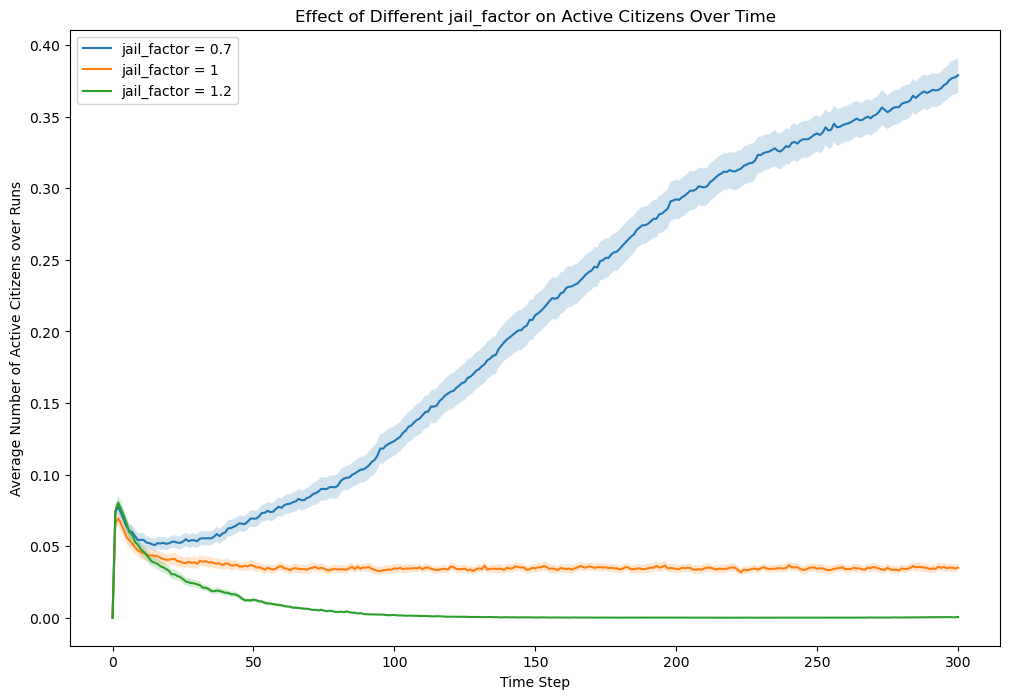

In [11]:
# change jail_factor in basic model, simulated for 100 times with condidence level 90%
jail_factor = [0.7, 1, 1.2]
num_runs = 100
save_dir = 'saved_data_jail_factor_basic' # Directory to save the data
data_handler = ModelDataHandler(save_dir)
results = {}

for jail_factor in tqdm(jail_factor, desc="Overall Progress"):
    results[jail_factor] = run_model_with_different_jail_factor(jail_factor, num_runs, data_handler)

# Plot the results:
plot_results(results)

In [ ]:
# model server to observe agents activity
 
COP_COLOR = "#000000"
AGENT_QUIET_COLOR = "#648FFF"
AGENT_REBEL_COLOR = "#FE6100"
JAIL_COLOR = "#808080"
JAIL_SHAPE = "rect"


def citizen_cop_portrayal(agent):
    if agent is None:
        return

    portrayal = {
        "Shape": "circle",
        "x": agent.pos[0],
        "y": agent.pos[1],
        "Filled": "true",
    }

    if type(agent) is Inhabitant:
        color = (
            AGENT_QUIET_COLOR if agent.condition == "Quiescent" else AGENT_REBEL_COLOR
        )
        color = JAIL_COLOR if agent.jail_sentence else color
        shape = JAIL_SHAPE if agent.jail_sentence else "circle"
        portrayal["Color"] = color
        portrayal["Shape"] = shape
        if shape == "rect":
            portrayal["w"] = 0.9
            portrayal["h"] = 0.9
        else:
            portrayal["r"] = 0.5
            portrayal["Filled"] = "false"
        portrayal["Layer"] = 0

    elif type(agent) is Police:
        portrayal["Color"] = COP_COLOR
        portrayal["r"] = 0.9
        portrayal["Layer"] = 1

    return portrayal


model_params = {
    "height": 40,
    "width": 40,
    "legitimacy_matrix": np.array([[0.95, 0.87, 0.79],[0.71, 0.63, 0.55]]),
    "citizen_density": mesa.visualization.Slider(
        "Initial Agent Density", 0.7, 0.0, 0.9, 0.1
    ),
    "cop_density": mesa.visualization.Slider(
        "Initial Cop Density", 0.05, 0.0, 0.1, 0.01
    ),
    "citizen_vision": mesa.visualization.Slider("Citizen Vision", 6, 1, 10, 1),
    "cop_vision": mesa.visualization.Slider("Cop Vision", 5, 1, 10, 1),
    "legitimacy": mesa.visualization.Slider(
        "Government Legitimacy", 0.75, 0.0, 1, 0.01
    ),
    "max_jail_term": mesa.visualization.Slider("Max Jail Term", 15, 0, 50, 1),
    "alpha": mesa.visualization.Slider("Alpha", 0.0, 0.0, 0.5, 0.1),
    "jail_factor": mesa.visualization.Slider("Jail Factor", 1.0, 1.0, 1.5, 0.1),
    "use_mean_field": mesa.visualization.Slider("Use Mean Field", 1, 0, 1, 1),
    "legitimacy_impact": mesa.visualization.Slider("Legitimacy Impact", 0.01, 0.0, 1, 0.01),
    "legitimacy_width": mesa.visualization.Slider("legitimacy_width", 0.1, 0.0, 0.5, 0.01),
    # "incitation_threshold": mesa.visualization.Slider("Incitation Threshold", 10, 0.0, 100, 10),
    "legitimacy_type": mesa.visualization.Choice("Legitimacy Type", value="basic", choices=["basic", "heterogeneous", "by_regions"])
}
canvas_element = mesa.visualization.CanvasGrid(citizen_cop_portrayal, 40, 40, 480, 480)
chart = mesa.visualization.ChartModule(
    [
        {"Label": "Quiescent", "Color": "#648FFF"},
        {"Label": "Active", "Color": "#FE6100"},
        {"Label": "Jailed", "Color": "#808080"},
    ],
    data_collector_name="datacollector",
)
server = mesa.visualization.ModularServer(
    EpsteinNetworkCivilViolence,
    [
        canvas_element,
        chart,
    ],
    "Epstein Network Civil Violence",
    model_params,
)

server.launch()

Interface starting at http://127.0.0.1:8521
Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
